$$\textbf{u}=-\frac{\textbf{k}}{\mu}(\nabla p - \rho g)$$

$$\phi \frac{\partial p}{\partial t} - \frac{1}{\mu} \nabla \cdot (\textbf{k} \nabla p) = q$$




In [1]:
from mpi4py import MPI
from dolfinx import mesh
import ufl
import numpy as np
from dolfinx import fem

class BoundaryCondition():
    def __init__(self, type, marker, values,facet_tag, functionspace,fdim,ds=None):
        self._type = type
        if type == "Dirichlet":
            if callable(values):
                u_D = fem.Function(functionspace)
                u_D.interpolate(values)
                #facets = facet_tag.find(marker)
                facets = facet_tag.indices[facet_tag.values==1]
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(u_D, dofs)
            else:
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(values, dofs,functionspace) #wall_dofs, V)
        elif type == "Neumann":
                self._bc = ufl.inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * ufl.inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type
    



In [2]:
import numpy as np
from dolfinx import fem
from dolfinx import mesh
import ufl
from mpi4py import MPI
from petsc4py import PETSc

#from basix.ufl import element



In [3]:
#from basix import ufl
import dolfinx
print(dolfinx.__version__)
import basix
print(basix.__version__)

0.4.1
0.4.2


In [4]:
#domain = mesh.create_unit_square(MPI.COMM_WORLD, 20, 20)

domain = mesh.create_unit_cube(MPI.COMM_WORLD, 20,20,20)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

x = ufl.SpatialCoordinate(domain)

t = 0
T = 10
num_steps = 1000

dt = T / num_steps

def K(x):
    #return 1.0/(ufl.exp(-(((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1)*((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1))) + 1.0)
    return 1.0*ufl.exp(-1*((x[0]-0.5)**2+(x[1]-0.5)**2+(x[2]-0.5)**2)/0.1)
    #return 0.1

n = ufl.FacetNormal(domain)
q = fem.Constant(domain, PETSc.ScalarType(0))
dt_ = fem.Constant(domain, PETSc.ScalarType(dt))
mu = fem.Constant(domain, PETSc.ScalarType(0.3))
phi = fem.Constant(domain, PETSc.ScalarType(0.5))

#Elements
#s_cg1 = element("Lagrange", domain.topology.cell_name(), 1)
#P = fem.FunctionSpace(domain, ("Lagrange", domain.topology.cell_name(), 2))
P = fem.FunctionSpace(domain,("Lagrange", 1))

p = ufl.TrialFunction(P)
v = ufl.TestFunction(P)

#Boundaries
boundaries=[
    (1, lambda x: np.isclose(x[0],0)), # x=0
    (2, lambda x: np.isclose(x[0],1)), # x=1
    (3, lambda x: np.isclose(x[1],0)), # y=0
    (4, lambda x: np.isclose(x[1],1)), # y=1
    (5, lambda x: np.isclose(x[2],0)), # z=0
    (6, lambda x: np.isclose(x[2],1)) # z=1
]

facet_indices,facet_markers=[],[]
for (marker, locator) in boundaries:
    facets= mesh.locate_entities(domain,fdim,locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets,marker))
facet_indices=np.hstack(facet_indices).astype(np.int32)
facet_markers=np.hstack(facet_markers).astype(np.int32)
sorted_facets=np.argsort(facet_indices)
facet_tag=mesh.meshtags(domain,fdim,facet_indices[sorted_facets],facet_markers[sorted_facets])

#x_ufl = 1 + x[0] + 2 * x[1]

#h = - ufl.div(K(x_ufl) * ufl.grad(x_ufl))

pressure_boundary_conditions=[
    BoundaryCondition("Dirichlet", 1, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 2, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 3, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 4, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 5, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 6, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc
                      ]

## Discretization in time

$$\frac{\partial p}{\partial t} \approx \left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right )$$

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$ p^{n+1} = p^{n} + \Delta t \left ( q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) \right )$$

## For Prediction Correction scheme

### Predictor:

$$\left ( \frac{p^{*}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n)$$
$$ p^{*} = p^{n} + \Delta t \left ( q^n + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right )$$

#### Solve for $p^*$, apply inner product:

$$\left \langle \frac{p^{*}-p^{n}}{\Delta t} ,v \right \rangle_{\Omega} = \langle q,v \rangle_{\Omega} + \left \langle \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right \rangle_{\Omega} $$

#### Solve for $p^{n+1}$, apply inner product:

### Corrector

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) =\frac{1}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})bla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

$$ p^{n+1} = p^{n} + \frac{\Delta t}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})) +
    (q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{2(p^{n+1}-p^{n})}{\Delta t} , v \right \rangle_{\Omega}  = 
\left \langle
    \left ( q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n}) \right ) +
    \left ( q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*}) \right ) 
    , v \right \rangle_{\Omega} 
    $$

## Basic euler time discretization

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$\left ( p^{n+1}-p^{n} \right ) = \Delta t q + \frac{\Delta t}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{p^{n+1}-p^{n}}{\Delta t} , v \right \rangle_{\Omega} = \left \langle q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) , v \right \rangle_{\Omega} $$


$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} = 
\Delta t \left \langle  q ,v \right \rangle_{\Omega} + 
\frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega} -
\Delta t \left \langle \nabla (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} 
- \frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega}
= \Delta t \left \langle  q ,v \right \rangle_{\Omega} 
 - \Delta t \left \langle (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

In [5]:
import dolfinx.fem.petsc

def initial_condition(x):
    #return np.array([0.1])
    return np.array([0.1])+x[0]*np.array([0.7])

# Define the variational problem for the first step
p_n = dolfinx.fem.Function(P)
p_n.name = "p_n"
p_n.interpolate(initial_condition)

ph = dolfinx.fem.Function(P)
ph.name = "ph"
ph.interpolate(initial_condition)

F1 = ufl.dot((p - p_n), v) * ufl.dx
F1 -= (dt_ / (phi*mu)) * K(x) * ufl.dot(ufl.grad(p), ufl.grad(v)) * ufl.dx
F1 -= dt_ *ufl.inner(q,v) * ufl.dx
#F1 -= dt_ * ufl.inner(h,v) * ufl.dx
#F1 += ufl.dot(p_n * n, v) * ufl.ds - ufl.dot(mu * ufl.nabla_grad(U) * n, v) * ufl.ds

a1 = fem.form(ufl.lhs(F1))
L1 = fem.form(ufl.rhs(F1))
import dolfinx.fem.petsc
A1 = fem.petsc.assemble_matrix(a1, bcs=pressure_boundary_conditions)
A1.assemble()
b1 = fem.petsc.create_vector(L1)

In [6]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")


In [7]:
from dolfinx.io import VTXWriter
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
#vtx_u = VTXWriter(domain.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(domain.comm, folder / "darcy_fluid_p.bp", p_n, engine="BP4")
vtx_p.write(t)

ImportError: cannot import name 'VTXWriter' from 'dolfinx.io' (/usr/lib/petsc/lib/python3/dist-packages/dolfinx/io.py)

In [8]:
def u_exact(x):
#    print(x.shape)
    values = np.zeros((1, x.shape[1]), dtype=PETSc.ScalarType)
#    print(values.shape)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = fem.Function(P)
u_ex.interpolate(u_exact)

#L2_error = fem.form(ufl.dot(u_ - u_ex, u_ - u_ex) * ufl.dx)

In [9]:
! apt-get update && apt install -y libgl1-mesa-glx xvfb
! pip3 install pyvista
! pip install imageio

Hit:1 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu focal InRelease   
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease    
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Fetched 256 kB in 2s (105 kB/s)    
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.20).
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


In [10]:
import pyvista
from dolfinx import plot
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(P))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif", fps=10)

grid.point_data["ph"] = ph.x.array
#warped = grid.warp_by_scalar("ph", factor=1)

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.01)

renderer = plotter.add_mesh(grid, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(ph.x.array)])


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 0.01


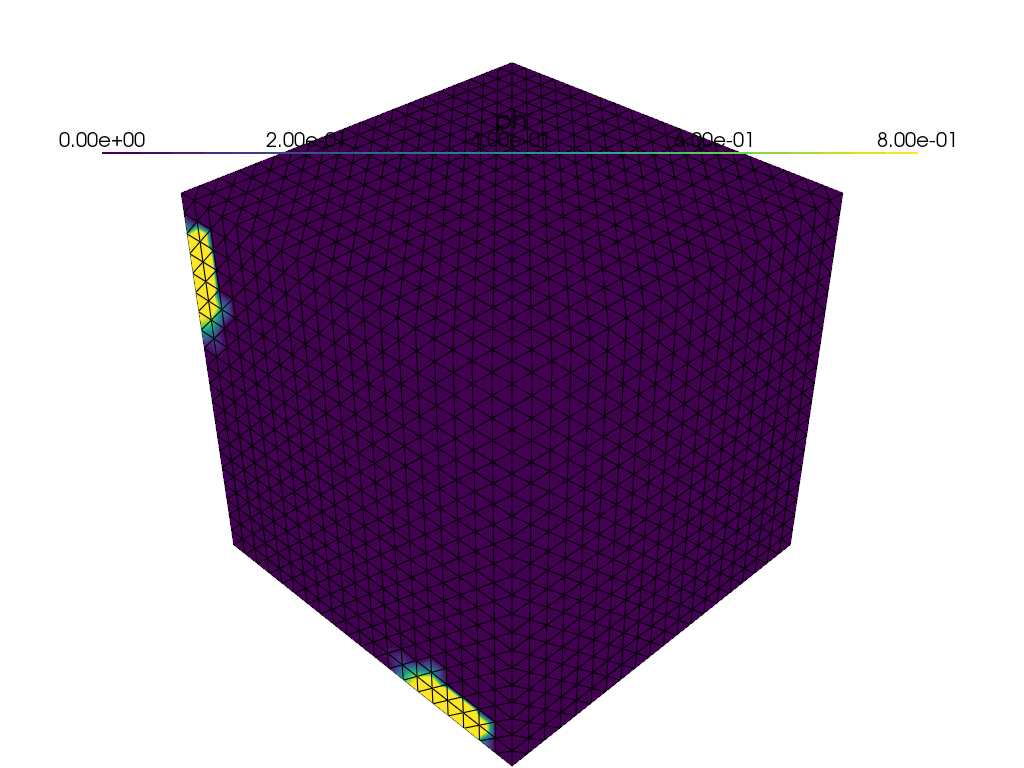


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 1.01


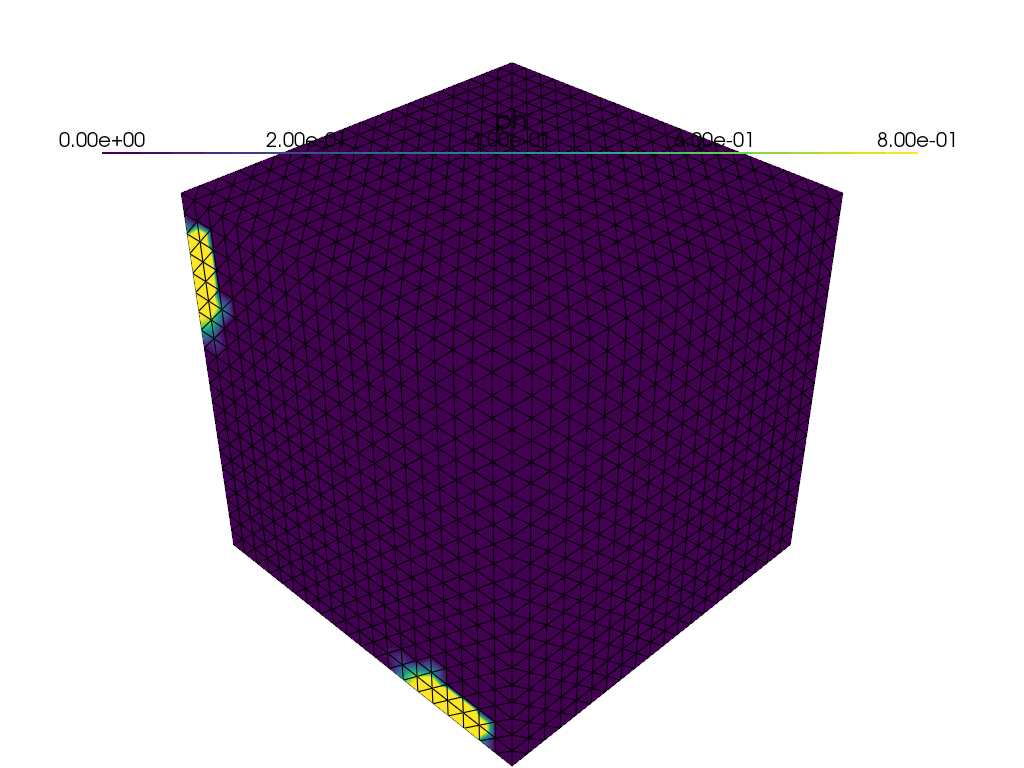


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 2.01


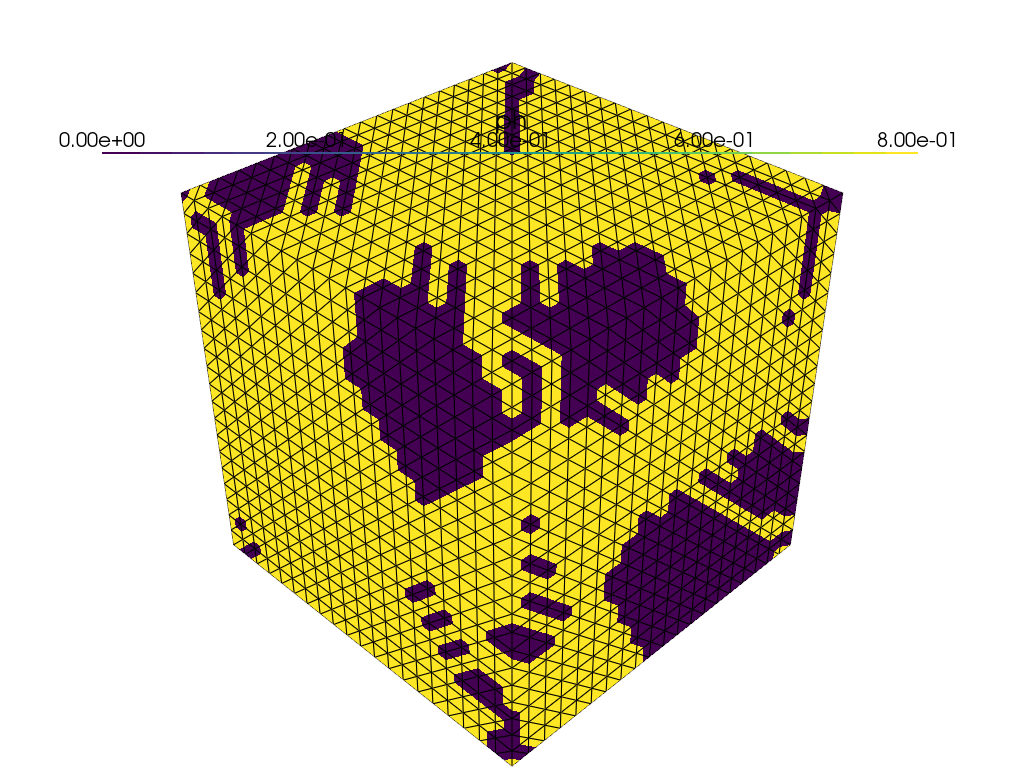


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 3.01


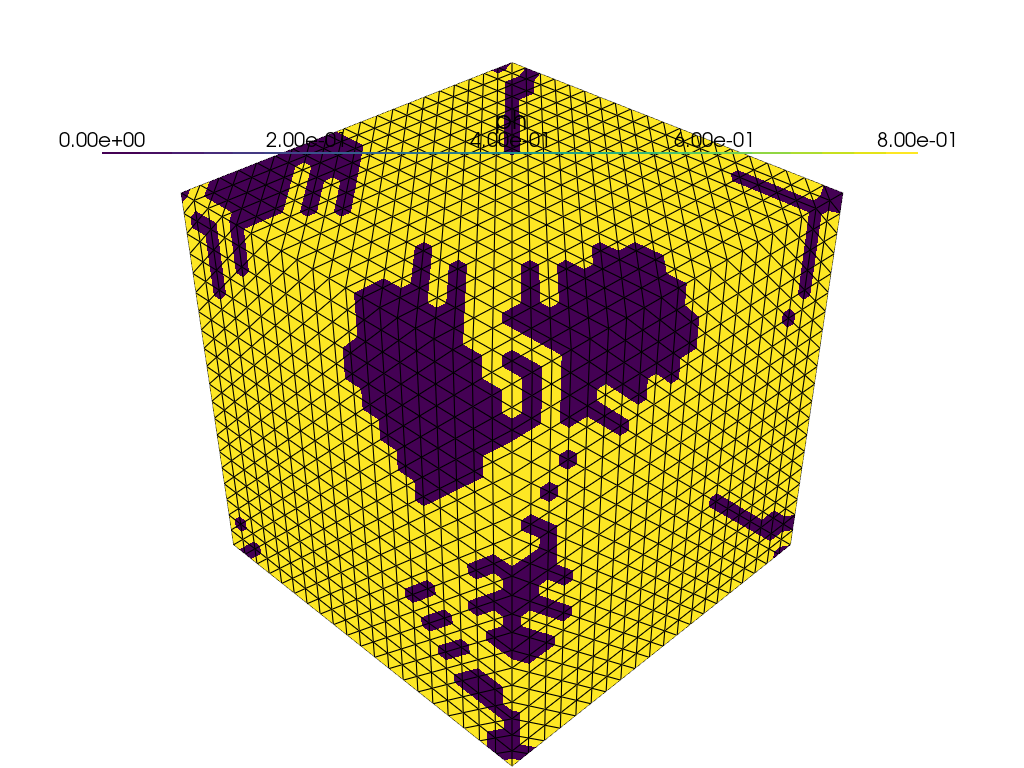


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 4.01


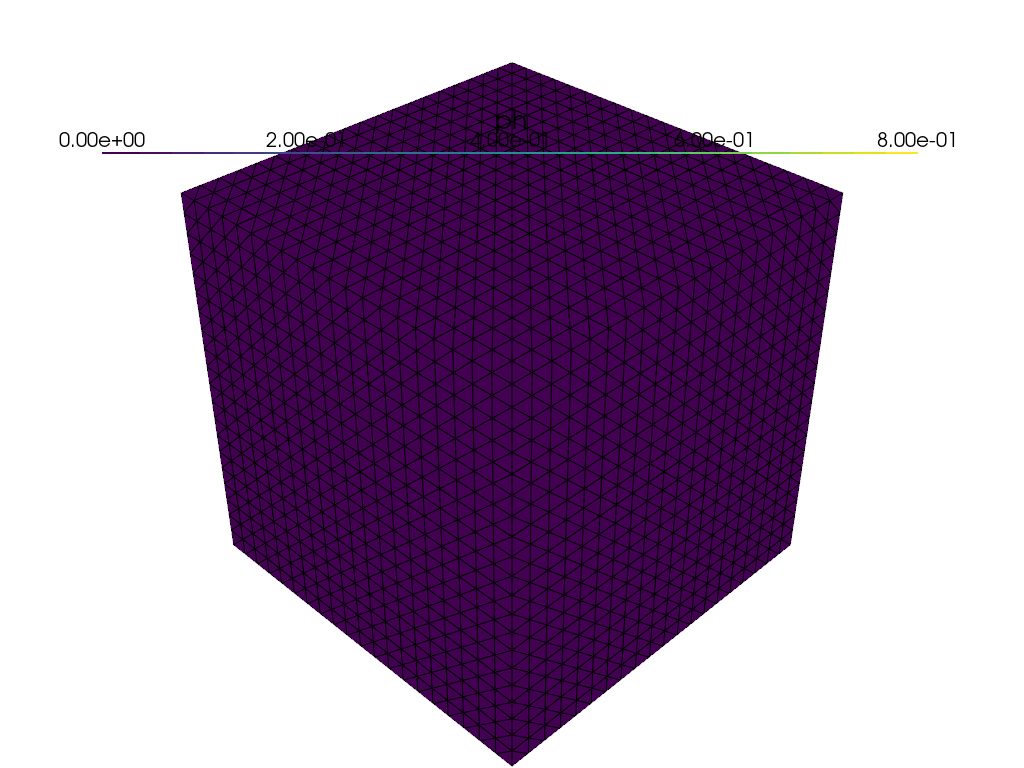


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 5.01


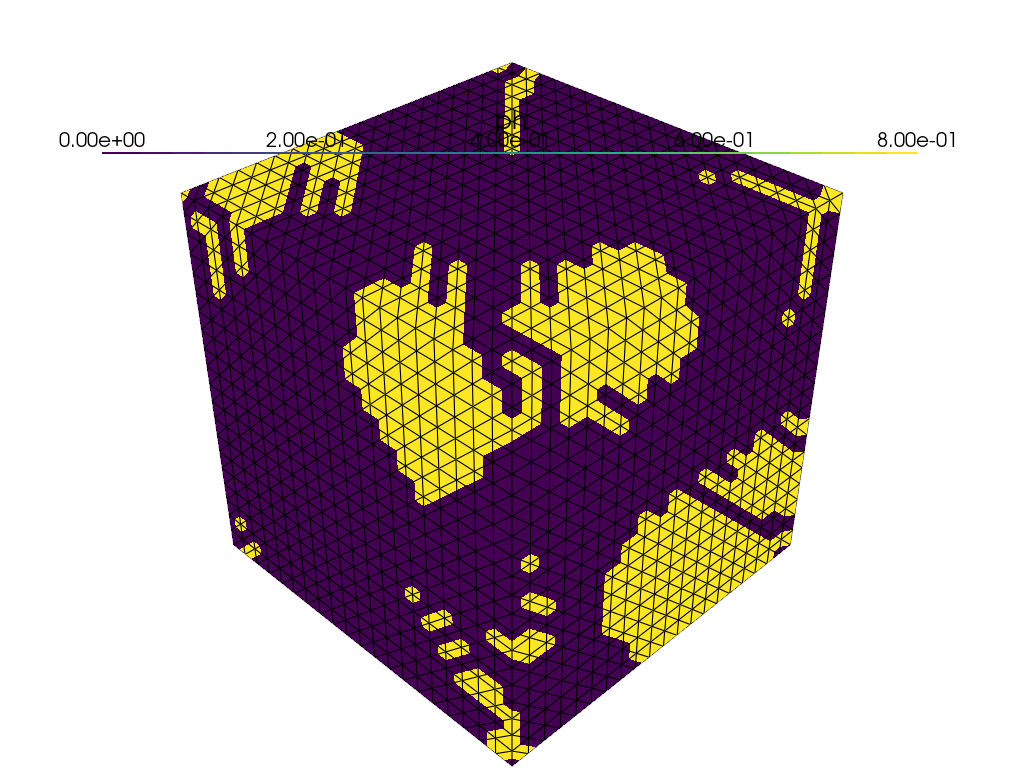


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 6.01


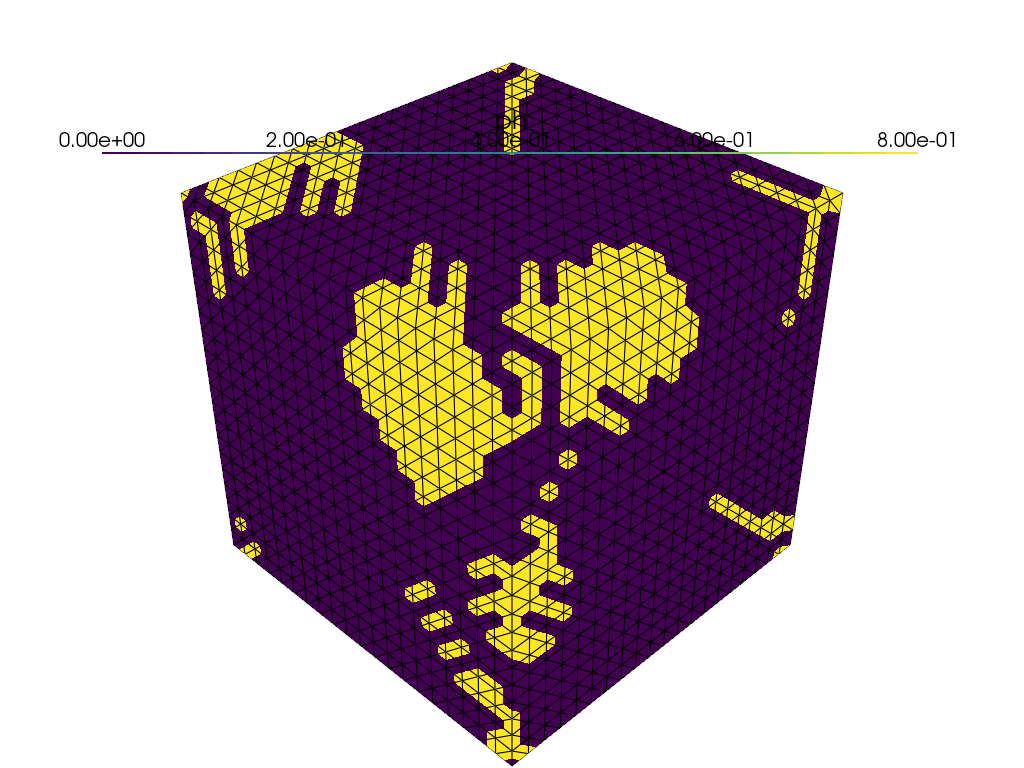


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 7.01


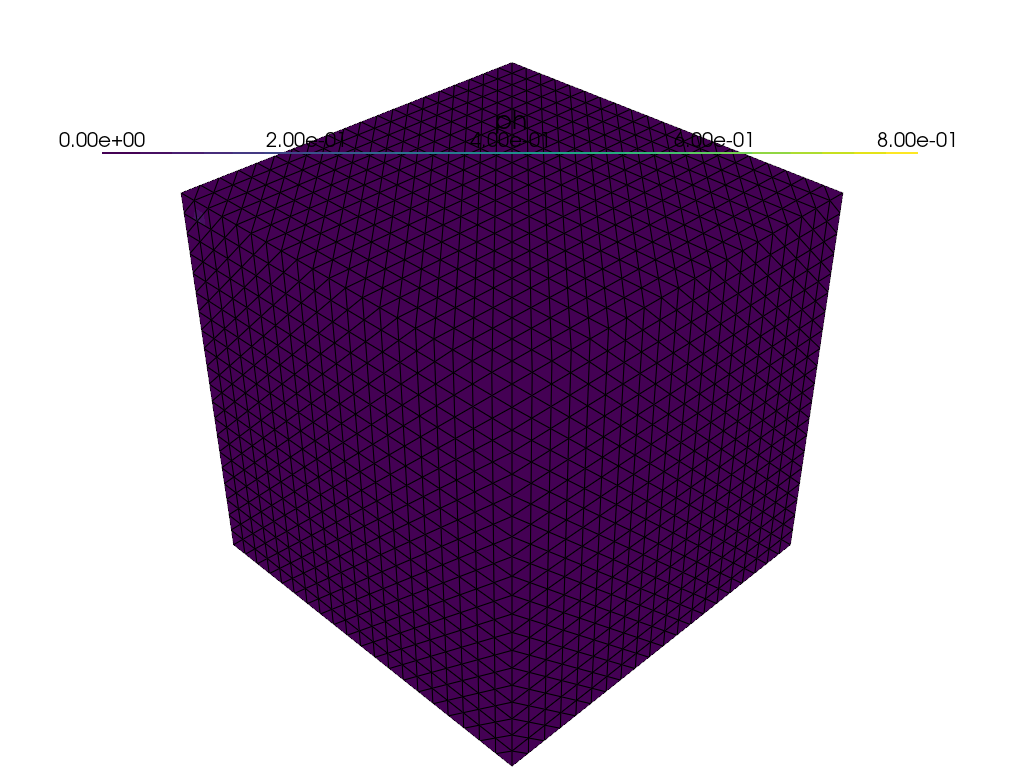


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 8.01


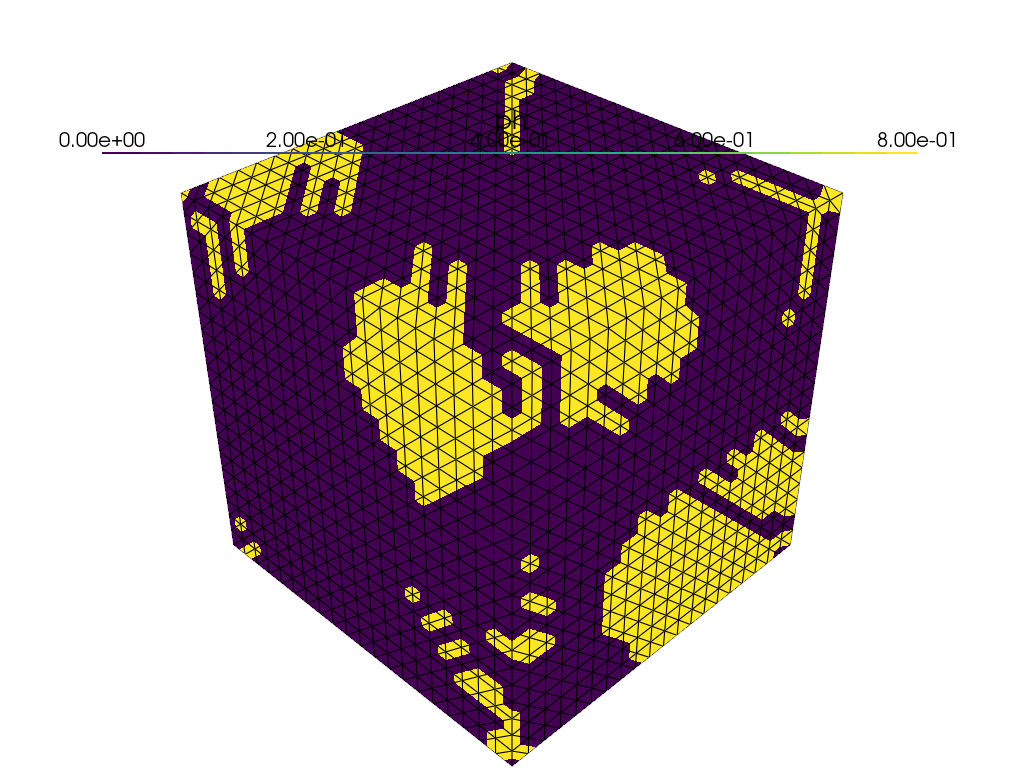


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 9.01


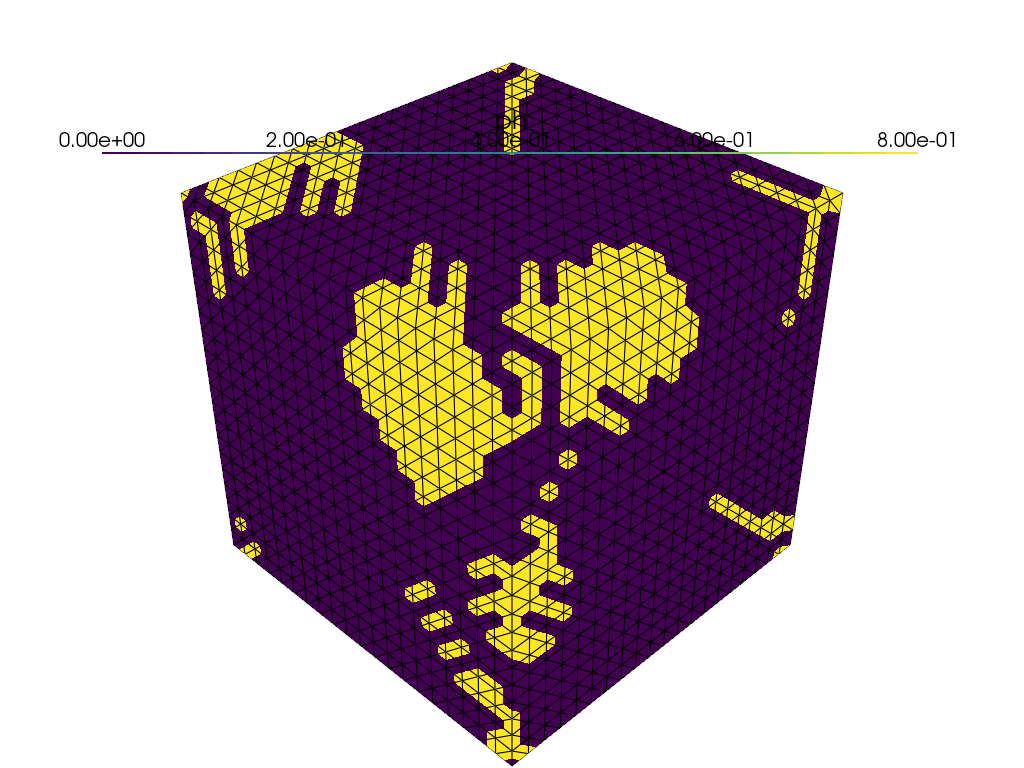


No module named 'trame'

Falling back to a static output.
  warnings.warn(



Time 10.00


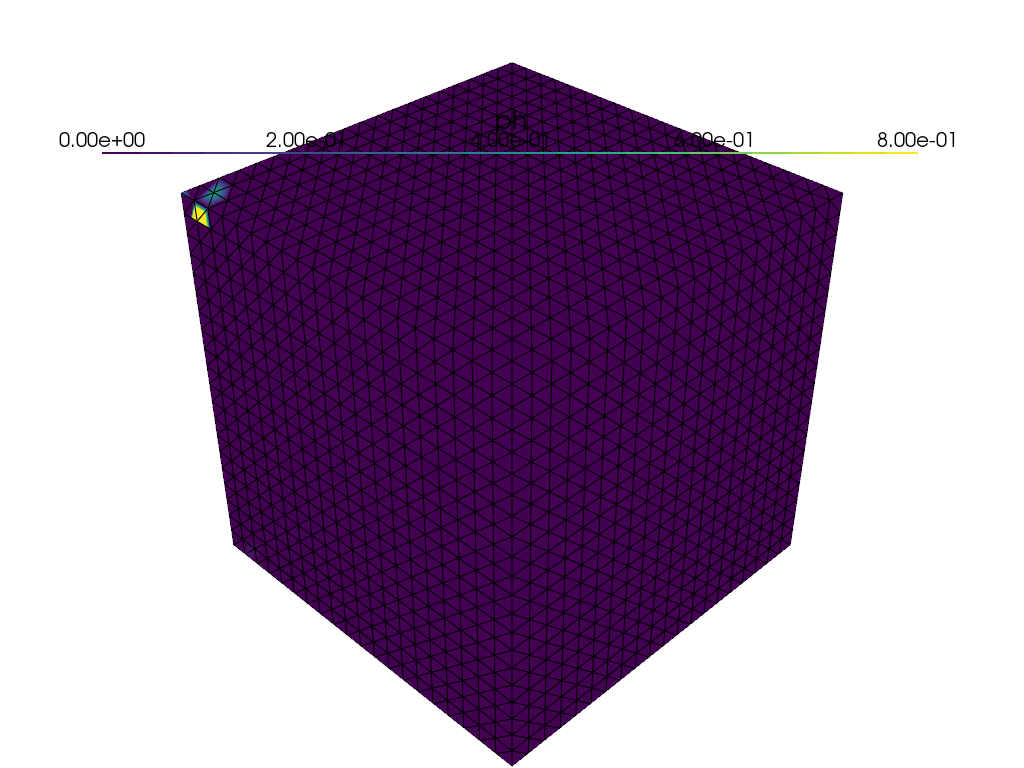

In [11]:
from copy import copy
Pv=[]
Vv=[]
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    dolfinx.fem.petsc.assemble_vector(b1, L1)
    dolfinx.fem.petsc.apply_lifting(b1, [a1], [pressure_boundary_conditions])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.petsc.set_bc(b1, pressure_boundary_conditions)
    solver1.solve(b1, ph.vector)
    ph.x.scatter_forward()

#    Pv.append(p_n.eval(domain.geometry.x,np.arange(121)))
#    Vv.append(u_n.eval(domain.geometry.x,np.arange(121)))

    # Write solutions to file
    #vtx_p.write(t)

    p_n.x.array[:] = ph.x.array
    Pv.append(copy(ph.x.array))

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    #warped.points[:, :] = new_warped.points
    #warped.point_data["ph"][:] = ph.x.array
    #plotter.write_frame()

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    new_grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(P))
    grid.points[:, :] = new_grid.points
    grid.point_data["ph"][:] = ph.x.array
    plotter.write_frame()
    

    # Compute error at current time-step
    #error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(L2_error), op=MPI.SUM))
    #error_max = domain.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 100 == 0) or (i == num_steps - 1):
        #print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
        print(f"Time {t:.2f}")
        plotter.show()
# Close xmdf file
#plotter.close()
#vtx_p.close()
b1.destroy()
solver1.destroy()

TypeError: Invalid shape (21, 21, 21) for image data

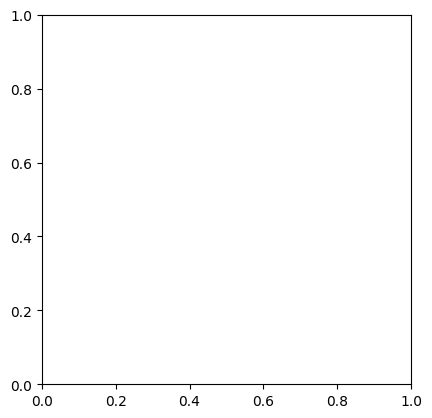

In [ ]:
mpl.pyplot.imshow(Pv[-1].reshape(21,21,21))
mpl.pyplot.colorbar()
len(Pv)

In [12]:
import pandas as pd
import os
from einops import repeat,rearrange

def solution_data_normalization(P,X):
    #Uv_=P
    Uv_=rearrange(np.array(P),"a b -> a b 1")
    X=repeat(domain.geometry.x[:,:],"p v -> t p v",t=1000)
    T=repeat(np.array([dt*t for t in range(1,1001)]),"t -> t p 1",p=21*21*21)
    XT=np.concatenate([X,T],axis=-1)
    Uv_=rearrange(Uv_,"t p v -> (t p) v")
    XT=rearrange(XT,"t p v -> (t p) v")

    data_dict={
        "p":Uv_[:,0].tolist(),
        "x":XT[:,0].tolist(),
        "y":XT[:,1].tolist(),
        "z":XT[:,2].tolist(),
        "t":XT[:,3].tolist()
    }
    return pd.DataFrame(data_dict)
Vv_=np.array(Vv)
Pv_=np.array(Pv)

In [13]:
data=solution_data_normalization(np.array(Pv),domain.geometry.x)
data

p     x     y     z      t
0       -1.714790e-06  0.95  0.00  0.00   0.01
1        1.726788e-06  1.00  0.00  0.00   0.01
2       -3.823168e-06  1.00  0.05  0.00   0.01
3        8.042441e-07  1.00  0.05  0.05   0.01
4        3.504159e-07  1.00  0.00  0.05   0.01
...               ...   ...   ...   ...    ...
9260995 -2.327954e-49  0.00  1.00  0.90  10.00
9260996  1.062513e+15  0.05  1.00  1.00  10.00
9260997 -2.327954e-49  0.00  1.00  0.95  10.00
9260998 -2.327954e-49  0.00  0.95  1.00  10.00
9260999 -2.327954e-49  0.00  1.00  1.00  10.00

[9261000 rows x 5 columns]

In [14]:
ROOT="/app/"
data.to_csv(os.path.join(ROOT,"Data/3D_1P_non_linear_DF_eq_Dirichlet_Linear_Linear_f_zero_S20x20x20_T10_1000.csv"))
#data.to_csv(os.path.join(ROOT,"Data/3D_1P_linear_DF_eq_Dirichlet_Linear_Linear_f_zero_S20x20x20_T10_1000.csv"))
#data.to_csv()

In [ ]:
!ls /app/

DL_models		Exps		 Train_differentiable_physics.py
Data			Notebooks	 Transforms
Dockerfile		Physical_models  bash_routines
Dockerfile.pytorch	README.md	 srm_routines
Dockerfile.pytorch.SD2	Train.py	 sympytorch
